## 1. Physical Structure (only aleatory uncertainties in the responses/time series)

The cross-section of the mast is changed from a pipe to a rectangular truss structure to avoid modeling cross-wind vibrations.

The truss structure is based on pictures from Sender Aholming, a guyed truss mast, and parameters are chosen such that mass per meter and second area of moments equal that of the pipe structure, thus previous results can be used.

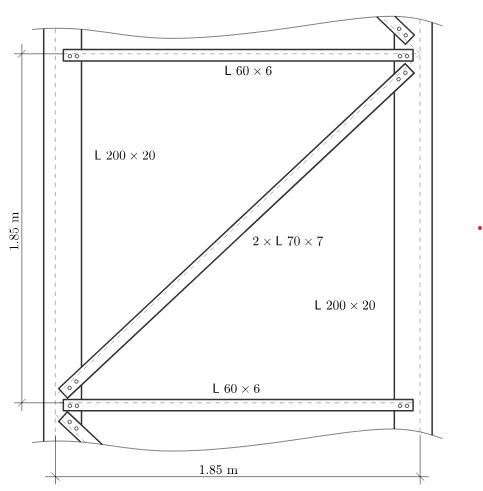

The truss consist of equal leg steel angle profiles. The corners are 200 x 20, the horizontal members are 60 x 6 and the diagonals are two 70 x 7 bolted together on either side of the corner members flange.

The cross-section can be rotated randomly to contain modes of both directions in each sensor signal and also make sure, the equivalent springs do not act in the principal directions of the cross-section.

Wind excitation is based on EN 1991-1-4 with parameters from [Clobes 2008] and the method given by [Solari 2001], [Shinozuka 1972]. Wind direction is fixed to the models coordinate system, as the cross-section can be rotated w.r.t. the wind direction. Basic wind speed $v_b$ (given fixed in EN 1991-1-4) could be considered as random (Weibull, with parameters as estimated from Geyer monitoring data: $c={0.75:[2.267, 2.3],0.25:[1.96, 2.01]}$, $\lambda={0.75:[5.618, 5.649], 0.25:[5.91,6.0]}$, parameters seem to be independent $\rho= {0.03, 0.3}$). 


Other parameters such as integral lengths $L(z)$, correlation lengths $C_{k,j}$ ($k: {u,v,w}, j: {x,y,z}$), spectral bandwidth $f_{s,w}$ might be considered random or fixed.

#### Given parameters (sample Nr. 566)

$E = 2.1e11$ N/m^2                                           Young's Modulus                                       
$\rho = 7850$ kg/m^3                                         Mass density                                          
$A = 0.034251 $ m                                            equivalent cross-section area (average per meter)
$I_y = 0.013353 $ m                                          second moment of area (equivalent of a truss. 80 %)                             
$I_z = 0.013716 $ m                                          second moment of area (equivalent of a truss. 80 %)                             
$m_\text{add} = 58.477412$ kg/m                              Additional Mass (Platforms, Cables, Antennas, etc.)   
$N_\text{cbl} = 67978.166088$                                Pretension of guy cables  (Normal distr.)             
$A_\text{cbl} = 0.000785$                                    Cross-Sectional Area of cables                        
$\zeta_\mathrm{glob} = 0.008117$                             Glob. damp.: low / med. vibr.                         
$d_\text{D} = 284.903024$                                    TMD viscosity due to temperature-dependent silicon-oil
$m_\text{D} = 800$                                           TMD mass                                              
$k_{\mathrm{D}} = 1025.48$                                   TMD stiffness                                         
$n_\text{nodes} = 600$                                       Number of nodes, incl. internal nodes                 
$n_m = 14$                                                   Number of modes considered

#### Problems to be decided:

- Mode shapes should be scaled to unity at the mast tip, why?

#### Case studies with respect to closely-spaced modes (variable $b$) and global damping (variable $\zeta$)

1. $b=0.85$, $\zeta = 0.002$ (reference)
2. $b=0.85$, $\zeta = 0.0005$ (light damping)
3. $b=0.85$, $\zeta = 0.005$ (heavy damping)
4. $b=0.89xx$, $\zeta = 0.002$ (closely-spaced modes)

#### Parameters to be set based on assumptions in subsequent steps:
- Solution time-step: Should be much smaller than for any desired sampling rate, will be increased in signal acquisition step -> based on highest sampling rate
- Solution max length: Will be shortened in signal acqusition step -> based on max measurement duration
- Solution No. channels: Will be reduced in signal acquisition step -> 50 (?)

#### Outputs
- numerical modal parameters (for control)
- numerical mode shapes (for control)
- 

## Structural Model generation


In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
%load_ext snakeviz
# dont forget to forward ports: ssh -L 8080:127.0.0.1:8080 sima9999@makalu47.rz.tu-ilmenau.de

import sys
import os
sys.path.append("/usr/wrk/people9/sima9999/code/")
sys.path.append("/vegas/users/staff/womo1998/Projects/2019_OMA_UQ/code/")

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from model.mechanical import Mechanical, MechanicalDummy
from model.turbulent_wind import *

# from uncertainty.polymorphic_uncertainty import PolyUQ
# from uncertainty.data_manager import DataManager

%aimport -sys -logging -matplotlib -matplotlib.pyplot -numpy -pandas - scipy.stats -scipy.stats.qmc

In [2]:
add_mass = 58.477412
zeta = 0.008117
dD = 284.903024
mD = 800
kD = 1025.48
num_nodes = 201
num_modes = 14

E = 2.1e11

A = 0.034251
Iy = 0.013353
Iz = 0.013716
# Iz = Iy
Iyz = 0

A_wire = 0.000785
rho = 7850
N_wire = 67978.166088

meas_locs=None
alpha = 0

# approximately similar second moments of area are achieved with a truss 
# consisting of 4 L profiles in the corners
# additionally, the diagonal and horizontal bracings have to be considered for the weight
# they add a weight of 0.016005*rho per meter, 
# so we need a cross-section area of 0.034634 m² to achieve the same weight per meter
# use a 200x200x20 L Profile at a 1.85 m distance slightly lower area, but similar moments of area
# (also see photos of Sender Aholming)
# use only the parts due to Steiner's theorem and reduce to 80 % due to truss flexibility
# A_L = (2*a*t - t*t)*4 = 0.0304
# Iy_L = 0.8*A_L*(L/2)**2 = 0.020809
# Iz_L = 0.8*A_L*(L/2)**2 = 0.020809
# also see excel workbook 'pipe_to_truss_conversion.xlsx'

# rotate cross section about angle alpha
alpha = alpha * 2 * np.pi / 360
rIy = 0.5 * (Iy + Iz) + 0.5 * (Iy - Iz) * np.cos(2 * alpha) + Iyz * np.sin(2 * alpha)
rIz = 0.5 * (Iy + Iz) - 0.5 * (Iy - Iz) * np.cos(2 * alpha) - Iyz * np.sin(2 * alpha)
rIyz = -0.5 * (Iy - Iz) * np.sin(2 * alpha) + Iyz * np.cos(2 * alpha)

Aeq = A_wire/(1 + (A_wire*rho*9.819*70/N_wire)**2*E*A_wire/12/N_wire)

keq = (E * Aeq * (70**2 / (70**2 + 160**2)) + N_wire)/np.sqrt(70**2 + 160**2)

rho_pipe = rho + add_mass / A

struct_parms = {
        'L'         : 200,

        'E'         : E,
        'A'         : A,
        'rho'       : rho_pipe,
        'Iy'        : rIy,
        'Iz'        : rIz,
        'Iyz'       : rIyz,

        'kz_nl'     : 1.7 * keq,
        'ky_nl'     : 2 * keq,
        # 'ky_nl'     : 1.7 * keq,
        'x_knl'     : 160,

        'm_tmd'     : 800,
        'ky_tmd'    : 1025.48,
        'kz_tmd'    : 1025.48,
        'dy_tmd'    : dD,
        'dz_tmd'    : dD,
        'x_tmd'     : 200,
        }


working_dir='/dev/shm/womo1998/'
global ansys
if 'ansys' not in globals():
    ansys = Mechanical.start_ansys(working_dir=working_dir)
mech = Mechanical(ansys=ansys, wdir=working_dir)

mech.build_conti(struct_parms, Ldiv=num_nodes, damping=zeta, 
                 num_modes=num_modes, meas_locs=meas_locs)
mech.modal()
pass

INFO:model.mechanical:Switching working directory:	 /dev/shm/womo1998/
INFO:model.mechanical:Current job:	 file


## Windfield generation

In [3]:
duration = 3600 # seconds

fs_w = 10 # Hz, Wind sample rate
# wind does not have to be generated up to higher frequencies, 
# as the energy in these bands is negligible

fs_m = 10 # Hz, Model sample rate
# sample rate is adjusted by zero padding the fft

N = int(duration * fs_w)
N_m =  int(duration * fs_m)

# Frequency domain grid
f_w = np.fft.rfftfreq(N, 1/fs_w)[:,np.newaxis]

# Spatial domain grid
x_grid = mech.nodes_coordinates[0:-2,1]

# Geländekategorie I - IV
category=3
z_min, alpha, vm_fact, vm_min, Iv_fact, Iv_min, eps = terrain_parameters(category)

# Windzone 1 - 4
# zone = 2
# v_b = [None, 22.5, 25.0, 27.5, 30][zone] # m/s Basiswindgeschwindigkeit (v_b = v_b0 in DE vgl. NA S. 5)
# draw sample from weibull distribution estimated from geyer wind data
v_b = scipy.stats.weibull_min.rvs(2.28,scale=5.64, size=1)

v_m, sigma_v, L = basic_wind_parameters(x_grid, v_b, z_min, alpha, vm_fact, vm_min, Iv_fact, Iv_min, eps)

C_uz = 10
C_vz = 7
C_wz = None

u_freq, v_freq = spectral_wind_field(x_grid, f_w, 
                                     L, v_m, sigma_v, C_uz=10, C_vz=7, C_wz=4, 
                                     seed=None)

u_time, v_time = temporal_wind_field(u_freq, v_freq, N_m)

INFO:model.turbulent_wind:A windfield of 201 x 18001 samples will be sampled at 10.0 Hz (duration 3600.0 s).
INFO:model.turbulent_wind:Random seed is: 859454217
Transforming windfield to time domain with 201 x 36000 samples.


In [4]:
# with mean wind
# F_uj, F_vj = force_wind_field(u_j + v_m[:,np.newaxis], v_j, delta_x=x_grid[1]-x_grid[0], 
#                               b=1.85, cscd=1.0, cf=2.36124, rho=1.25)
# without mean wind
Fu_time, Fv_time = force_wind_field(u_time, v_time, delta_x=x_grid[1]-x_grid[0], 
                              b=1.85, cscd=1.0, cf=2.36124, rho=1.25)

Fu_freq = np.fft.rfft(Fu_time, axis=0)
Fv_freq = np.fft.rfft(Fv_time, axis=0)

Computing forces from windfield with A_ref=1.85 and c_f = 2.36124


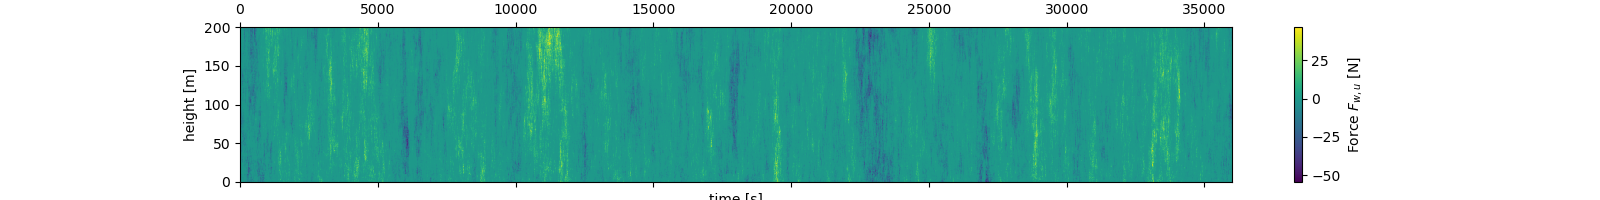

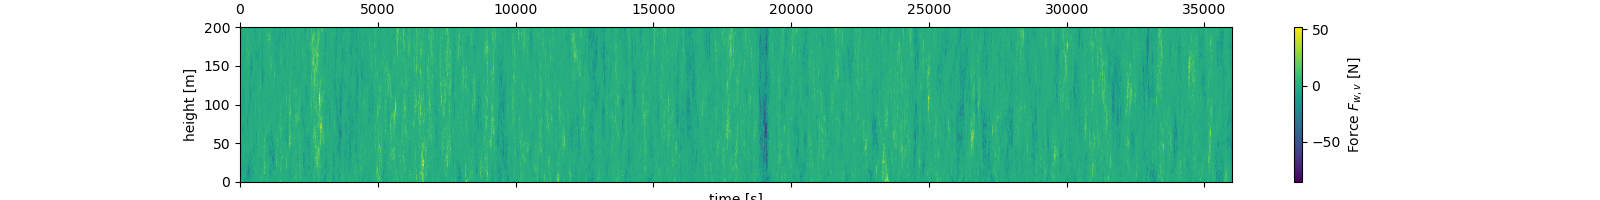

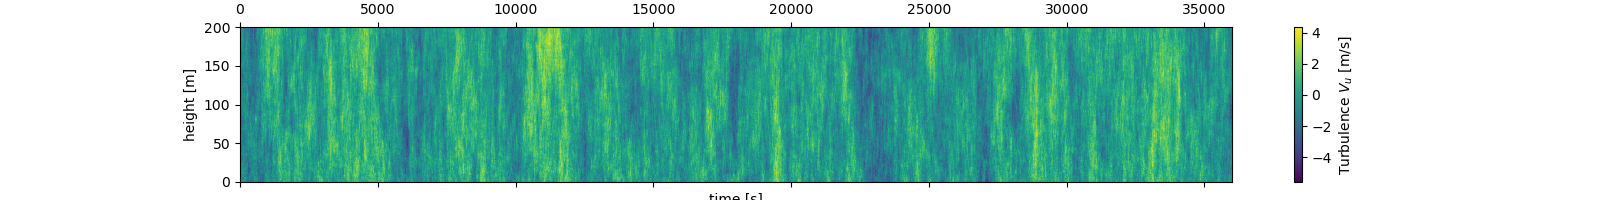

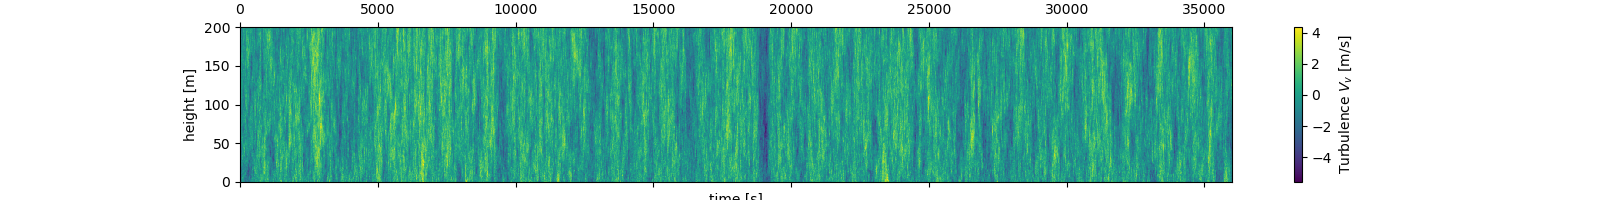

In [5]:
# plt.close('all')
plot_windfield(u_time.T, v_time.T, Fu_time.T, duration=duration)
plot_windfield(F_vj=Fv_time.T, duration=duration)

## Transient solution

In [8]:
%%time
# add zero channels for guy support node and tmd node
zeros = np.zeros((N_m, 1))
t, [d_time, v_time, a_time] = mech.transient(fy=np.hstack((Fu_time, zeros, zeros)), 
                                             fz=np.hstack((Fv_time, zeros, zeros)), 
                                             deltat=1 / fs_m, timesteps=N_m)
# remove DOF
d_time = d_time[:,:,1:]
v_time = v_time[:,:,1:]
a_time = a_time[:,:,1:]
# took 2:16+2:41+2:44+1:25

INFO:model.mechanical:Signal parameters for upcoming transient: deltat 0.100000, dt_fact for f_max 0.320264, timesteps 36000, num_cycles for f_min 591
INFO:model.mechanical:10000 of 36000 timesteps in 2m6s (Remaining ~7m34s; Disk free: 251.70 GB)
INFO:model.mechanical:20000 of 36000 timesteps in 2m17s (Remaining ~5m56s; Disk free: 251.70 GB)
INFO:model.mechanical:30000 of 36000 timesteps in 2m23s (Remaining ~3m49s; Disk free: 251.70 GB)
INFO:model.mechanical:40000 of 36000 timesteps in 1m26s (Remaining ~0m52s; Disk free: 251.74 GB)
CPU times: user 51.2 s, sys: 4.63 s, total: 55.8 s
Wall time: 8min 20s


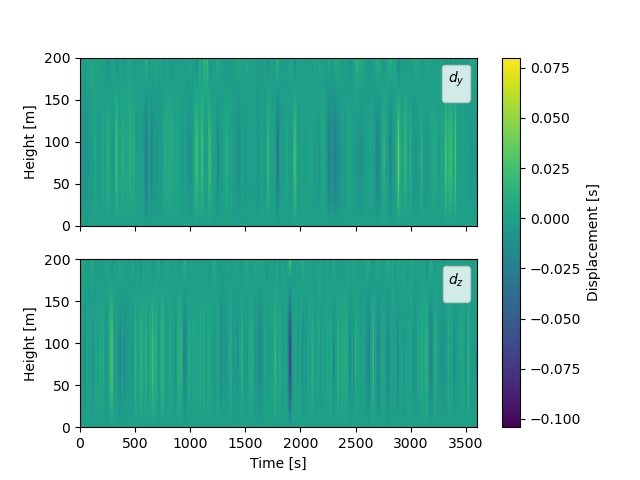

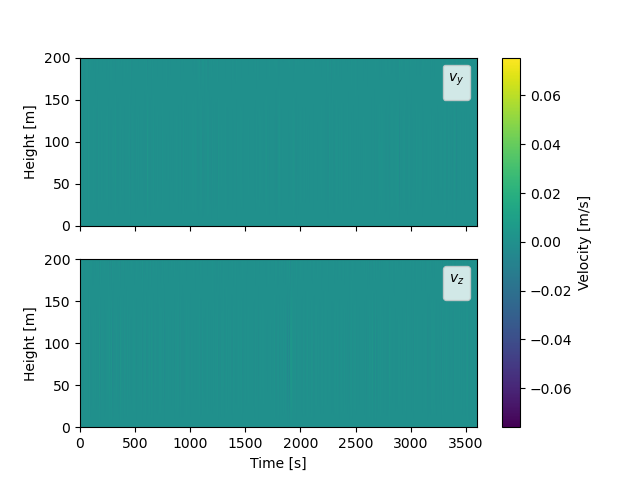

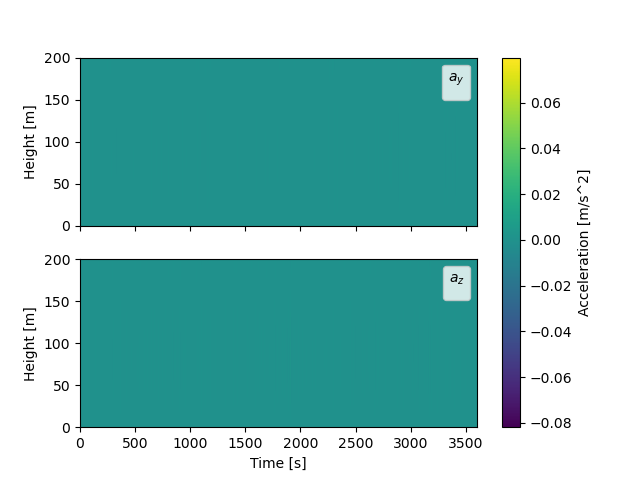

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True)
vmin, vmax = np.min(d_time), np.max(d_time)
im1 = axes[0].imshow(d_time[:,:,0].T, origin='lower', aspect='auto', extent=(0, duration, x_grid[0], x_grid[-1]), vmin=vmin, vmax=vmax, label='y')
im2 = axes[1].imshow(d_time[:,:,1].T, origin='lower', aspect='auto', extent=(0, duration, x_grid[0], x_grid[-1]), vmin=vmin, vmax=vmax, label='z')
fig.colorbar(im2, ax=axes).set_label('Displacement [s]')
axes[1].set_xlabel('Time [s]')
axes[1].set_ylabel('Height [m]')
axes[1].legend(title='$d_z$')
axes[0].set_ylabel('Height [m]')
axes[0].legend(title='$d_y$')

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True)
vmin, vmax = np.min(v_time), np.max(v_time)
im1 = axes[0].imshow(v_time[:,:,0].T, origin='lower', aspect='auto', extent=(0, duration, x_grid[0], x_grid[-1]), vmin=vmin, vmax=vmax, label='y')
im2 = axes[1].imshow(v_time[:,:,1].T, origin='lower', aspect='auto', extent=(0, duration, x_grid[0], x_grid[-1]), vmin=vmin, vmax=vmax, label='z')
fig.colorbar(im2, ax=axes).set_label('Velocity [m/s]')
axes[1].set_xlabel('Time [s]')
axes[1].set_ylabel('Height [m]')
axes[1].legend(title='$v_z$')
axes[0].set_ylabel('Height [m]')
axes[0].legend(title='$v_y$')

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True)
vmin, vmax = np.min(a_time), np.max(a_time)
im1 = axes[0].imshow(a_time[:,:,0].T, origin='lower', aspect='auto', extent=(0, duration, x_grid[0], x_grid[-1]), vmin=vmin, vmax=vmax, label='y')
im2 = axes[1].imshow(a_time[:,:,1].T, origin='lower', aspect='auto', extent=(0, duration, x_grid[0], x_grid[-1]), vmin=vmin, vmax=vmax, label='z')
fig.colorbar(im2, ax=axes).set_label('Acceleration [m/s^2]')
axes[1].set_xlabel('Time [s]')
axes[1].set_ylabel('Height [m]')
axes[1].legend(title='$a_z$')
axes[0].set_ylabel('Height [m]')
axes[0].legend(title='$a_y$')

## FRF Solution

In [20]:
# mech.omegas = None
time_values, [d_freq_time, v_freq_time, a_freq_time] = mech.transient_ifrf(Fu_freq, Fv_freq, 'freq', 
                    mech.nodes_coordinates[0:-2,0],
                    inp_dt = 1/fs_m)
d_freq = mech.d_freq
omegas = mech.omegas

INFO:model.mechanical:FRF computation for non-classical modes with 18001 frequency lines in the frequency range up to 5.0 Hz and 14 modes for 402 input and 406 output nodes.


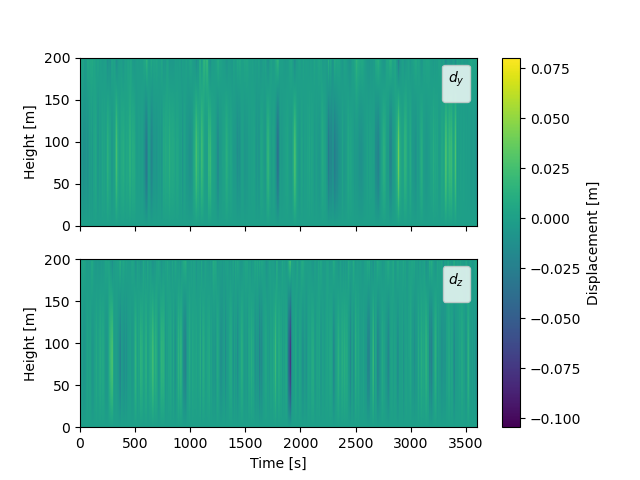

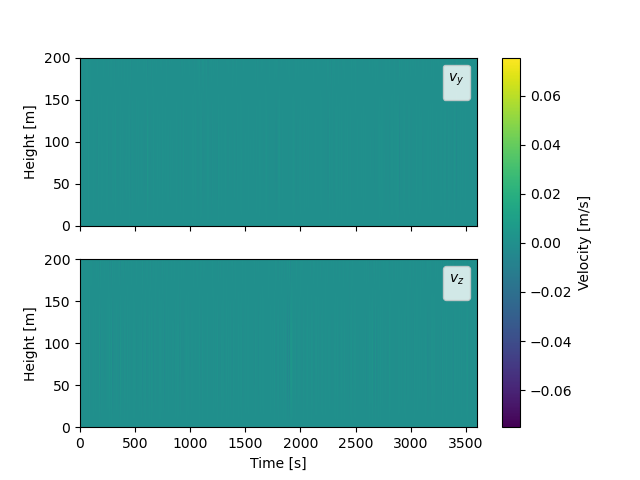

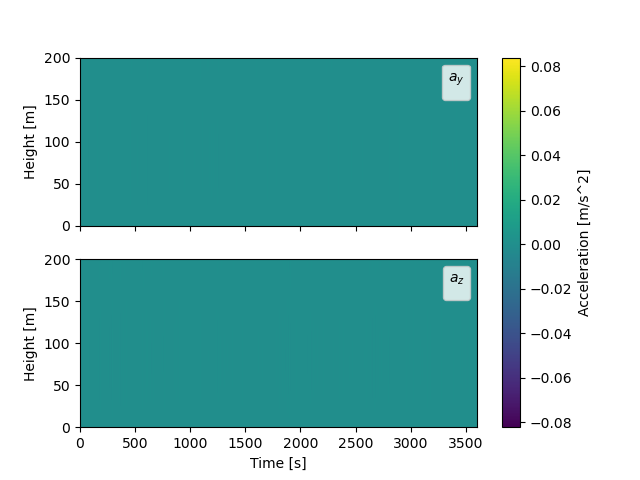

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True)
vmin, vmax = np.min(d_freq_time), np.max(d_freq_time)
im1 = axes[0].imshow(d_freq_time[:,:,0].T, origin='lower', aspect='auto', extent=(0, duration, x_grid[0], x_grid[-1]), vmin=vmin, vmax=vmax, label='y')
im2 = axes[1].imshow(d_freq_time[:,:,1].T, origin='lower', aspect='auto', extent=(0, duration, x_grid[0], x_grid[-1]), vmin=vmin, vmax=vmax, label='z')
fig.colorbar(im2, ax=axes).set_label('Displacement [m]')
axes[1].set_xlabel('Time [s]')
axes[1].set_ylabel('Height [m]')
axes[1].legend(title='$d_z$')
axes[0].set_ylabel('Height [m]')
axes[0].legend(title='$d_y$')

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True)
vmin, vmax = np.min(v_freq_time), np.max(v_freq_time)
im1 = axes[0].imshow(v_freq_time[:,:,0].T, origin='lower', aspect='auto', extent=(0, duration, x_grid[0], x_grid[-1]), vmin=vmin, vmax=vmax, label='y')
im2 = axes[1].imshow(v_freq_time[:,:,1].T, origin='lower', aspect='auto', extent=(0, duration, x_grid[0], x_grid[-1]), vmin=vmin, vmax=vmax, label='z')
fig.colorbar(im2, ax=axes).set_label('Velocity [m/s]')
axes[1].set_xlabel('Time [s]')
axes[1].set_ylabel('Height [m]')
axes[1].legend(title='$v_z$')
axes[0].set_ylabel('Height [m]')
axes[0].legend(title='$v_y$')

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True)
vmin, vmax = np.min(a_freq_time), np.max(a_freq_time)
im1 = axes[0].imshow(a_freq_time[:,:,0].T, origin='lower', aspect='auto', extent=(0, duration, x_grid[0], x_grid[-1]), vmin=vmin, vmax=vmax, label='y')
im2 = axes[1].imshow(a_freq_time[:,:,1].T, origin='lower', aspect='auto', extent=(0, duration, x_grid[0], x_grid[-1]), vmin=vmin, vmax=vmax, label='z')
fig.colorbar(im2, ax=axes).set_label('Acceleration [m/s^2]')
axes[1].set_xlabel('Time [s]')
axes[1].set_ylabel('Height [m]')
axes[1].legend(title='$a_z$')
axes[0].set_ylabel('Height [m]')
axes[0].legend(title='$a_y$')

## Verification FRF & Transient

### Animation

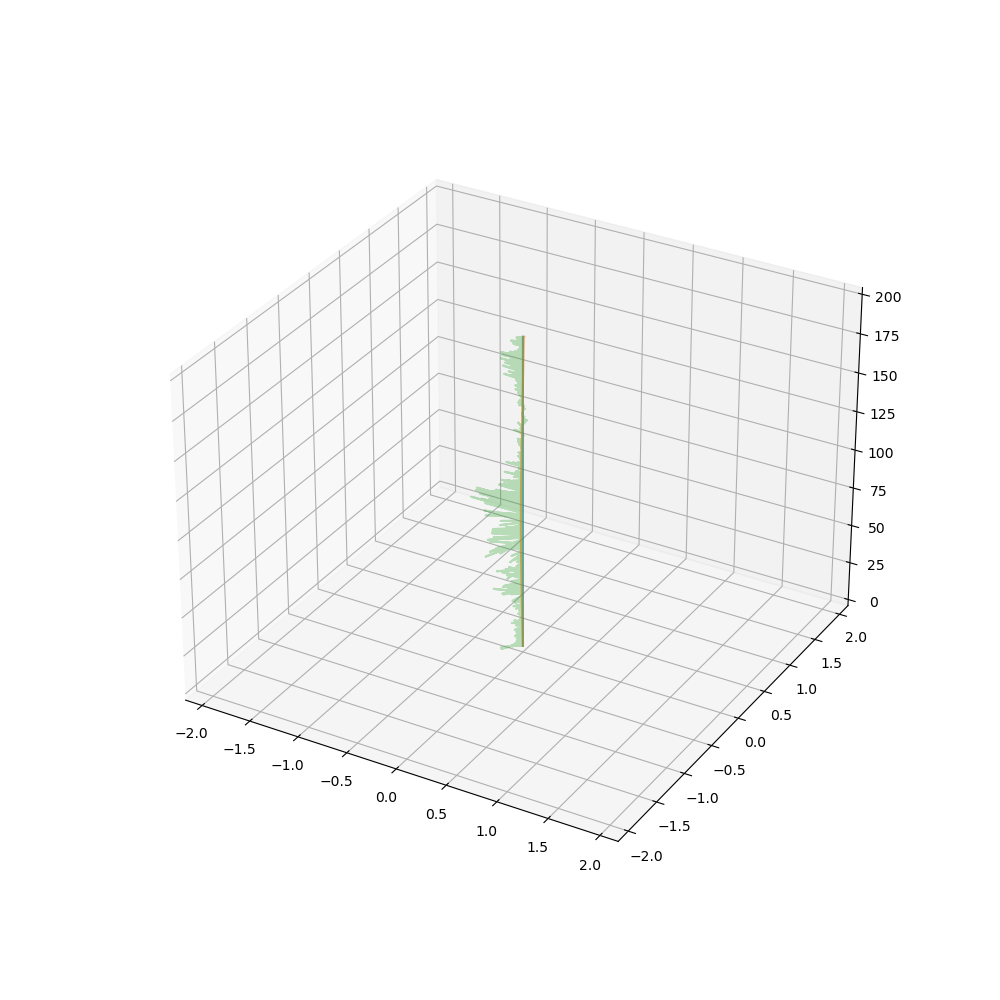

In [23]:
N_frames=25#N_m

# compare time histories by animating response side-by-side
from matplotlib.animation import FuncAnimation
plt.close('all')

ind = np.ones(num_nodes + 2, dtype=bool)
ind[-2] = False

if True: # transient results
    uy1 = d_time[:,ind,0]
    uz1 = d_time[:,ind,1]
else:
    uy1,uz1=None,None
if True: # FRF results
    uy2 = d_freq_time[:,ind,0]
    uz2 = d_freq_time[:,ind,1]
else:
    uy2,uz2=None,None    

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
z = x_grid
zero = np.zeros_like(z)

if uy1 is not None:
    lines_response1 = ax.plot(uy1[0, :], uz1[0, :], mech.nodes_coordinates[ind,1], alpha=0.6)[0]
    lim = np.max([-np.min(uy1), np.max(uy1), -np.min(uz1), np.max(uz1)])*20
else:
    lines_response1 = None

if uy2 is not None:
    lines_response2 = ax.plot(uy2[0, :], uz2[0, :], mech.nodes_coordinates[ind,1], alpha=0.6)[0]
    lim = np.max([-np.min(uy2), np.max(uy2), -np.min(uz2), np.max(uz2)])*20
else:
    lines_response2 = None
    
ax.set_xlim((-lim, lim))
ax.set_ylim((-lim, lim))


Flim = np.max([-np.min(Fu_time), np.max(Fu_time), -np.min(Fv_time), np.max(Fv_time)])

F_uj_inter = np.empty((3*len(x_grid),), dtype=Fu_time.dtype)
F_uj_inter[0::3] = zero
F_uj_inter[1::3] = Fu_time[0, :]*lim/Flim
F_uj_inter[2::3] = zero

F_vj_inter = np.empty((3*len(x_grid),), dtype=Fv_time.dtype)
F_vj_inter[0::3] = zero
F_vj_inter[1::3] = Fv_time[0, :]*lim/Flim
F_vj_inter[2::3] = zero

x_grid_inter = np.empty((3*len(x_grid),), dtype=x_grid.dtype)
x_grid_inter[0::3] = x_grid
x_grid_inter[1::3] = x_grid
x_grid_inter[2::3] = x_grid

lines_force = ax.plot(F_uj_inter, F_vj_inter, x_grid_inter, alpha=0.3)[0]

# lines_force+lines_response

def update(n):
    F_uj_inter[1::3] = Fu_time[n, :]*lim/Flim
    F_vj_inter[1::3] = Fv_time[n, :]*lim/Flim
    lines_force.set_data(F_uj_inter, F_vj_inter)
    lines_force.set_3d_properties(x_grid_inter)
    if uy1 is not None:
        lines_response1.set_data(uy1[n, :], uz1[n, :])
        lines_response1.set_3d_properties(mech.nodes_coordinates[ind,1])
    if uy2 is not None:
        lines_response2.set_data(uy2[n, :], uz2[n, :])
        lines_response2.set_3d_properties(mech.nodes_coordinates[ind,1])
        
    return lines_force

ani = FuncAnimation(fig, update, frames=N_m, blit=True, interval=33, repeat=False)
plt.show()   

In [24]:
ani.pause()
ani._stop()
plt.close('all')
del ani

### Spectra

Text(0, 0.5, 'Height [m]')

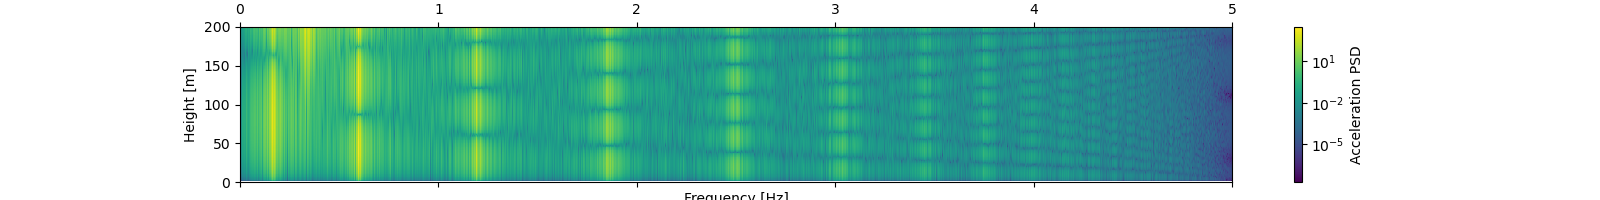

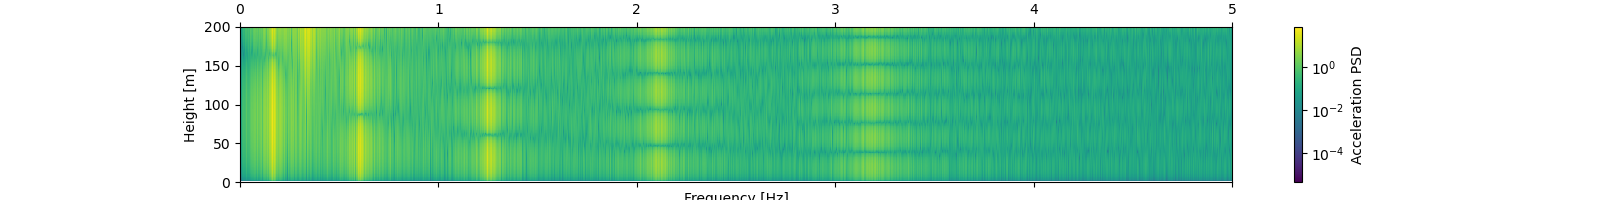

In [22]:
a_time_spec = np.fft.rfft(a_time, axis=0)**2
a_time_spec_polar_mag = np.abs(a_time_spec[:,:num_nodes,0].T) + np.abs(a_time_spec[:,:num_nodes,1].T)
plt.matshow(a_time_spec_polar_mag, origin='lower', aspect='auto', extent=(0, fs_m/2, x_grid[0], x_grid[-1]),norm='log')
plt.colorbar().set_label('Acceleration PSD')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Height [m]')

a_freq_spec = (d_freq * -1j * omegas[:, np.newaxis, np.newaxis]**2)
a_freq_spec_polar_mag = np.abs(a_freq_spec[:,:num_nodes, 0].T) + np.abs(a_freq_spec[:,:num_nodes, 1].T)
plt.matshow(a_freq_spec_polar_mag , origin='lower', aspect='auto', extent=(0, fs_m/2, x_grid[0], x_grid[-1]),norm='log')
plt.colorbar().set_label('Acceleration PSD')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Height [m]')

In [19]:
print(mech.damped_frequencies)

[0.1643798  0.16694399 0.17787979 0.17847569 0.33137084 0.3529869
 0.60317614 0.61512863 1.24779137 1.26994904 2.09316331 2.12480422
 3.15949507 3.20263827]


Text(0, 0.5, 'Acceleration PSD [ms^-2Hz^-1]')

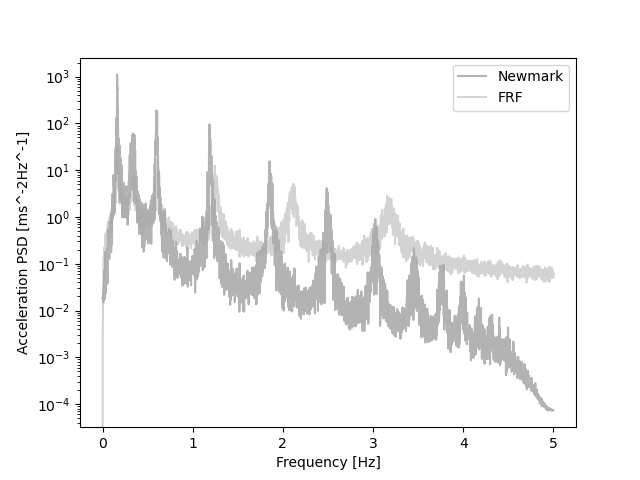

In [234]:
plt.figure()
plt.plot(f_w.squeeze(), np.mean(a_time_spec_polar_mag, axis=0), alpha=0.5, label='Newmark', color='dimgrey')
plt.plot(f_w.squeeze(), np.mean(a_freq_spec_polar_mag, axis=0), alpha=0.5, label='FRF', color='darkgrey')
# for i in range(2):
# plt.plot(f_w.squeeze(), a_spec_svd[0,:], alpha=0.5)
# plt.plot(f_w.squeeze(), outfrff_svd[0,:], alpha=0.5)
plt.yscale('log')
plt.legend()
plt.xlabel('Frequency [Hz]')
plt.ylabel('Acceleration PSD [ms^-2Hz^-1]')

## Validation

In [38]:
import xarray as xr

stats_wind = xr.load_dataset('/usr/scratch4/sima9999/work/stats_wind.nc')
stats_wind = stats_wind.where(stats_wind['error']==0)
stats_wind = stats_wind.sel(channels='Wg')
stats_wind = stats_wind.where(~np.isnan(stats_wind['mean']))
stats_wind = stats_wind.where(stats_wind['mean']<30)
stats_wind = stats_wind.where(np.log(stats_wind['mean'])>=-2)
stats_wind = stats_wind.where(np.sqrt(stats_wind['var'])/stats_wind['mean']<=0.2)
stats_wind = stats_wind.where(np.sqrt(stats_wind['var'])/stats_wind['mean']>=0.1)

stats_accel = xr.load_dataset('/usr/scratch4/sima9999/work/stats_accel.nc')
stats_accel = stats_accel.sel(channels=['Accel_01', 'Accel_02'])
stats_accel = stats_accel.where(stats_accel['rms']<0.2)

stats_wind, stats_accel = xr.align(stats_wind, stats_accel, exclude=['channels','modes'])

In [ ]:
def get_rms(v_b):
    v_m, sigma_v, L = basic_wind_parameters(x_grid, v_b, z_min, alpha, vm_fact, vm_min, Iv_fact, Iv_min, eps)
    
    c_uj, c_vj = spectral_wind_field(x_grid, f_w, 
                                     L, v_m, sigma_v, C_uz=10, C_vz=7, C_wz=4, 
                                     seed=None)
    
    u_j, v_j = temporal_wind_field(c_uj, c_vj, N_m)
    
    F_uj, F_vj = force_wind_field(u_j, v_j, delta_x=x_grid[1]-x_grid[0], 
                                  b=1.85, cscd=1.0, cf=2.36124, rho=1.25)
    
    fF_uj = np.fft.rfft(F_uj)
    fF_vj = np.fft.rfft(F_vj)
    
    fF = np.vstack([fF_uj, fF_vj]).T # n_lines, n_inp_nodes*n_inp_dofs
    outfrff = np.empty((N_m // 2 + 1, 2 * (num_nodes + 2)), dtype=complex)

    for i in range(N_m // 2 + 1):
        np.dot(fF[i,:], frf[i,:,:], out=outfrff[i,:])

    # dfrf = np.fft.irfft(outfrff, axis=0).T
    # vfrf = np.fft.irfft(outfrff* 1j*omegas[:, np.newaxis], axis=0).T
    afrf = np.fft.irfft(outfrff*-1j*omegas[:, np.newaxis]**2, axis=0).T

    # rms = np.sqrt(np.mean(afrf**2, axis=1))
    # acceleration level regardless of direction, exclude guy support node and tmd node
    rms = np.sqrt(np.mean(afrf[:(num_nodes),:]**2 + afrf[(num_nodes + 2):-2,:]**2, axis=1))
    return rms

v_b = scipy.stats.weibull_min.rvs(2.28,scale=5.64, size=1000)
rms = np.empty((num_nodes, v_b.shape[0]))
for i in range(v_b.shape[0]):
    rms[:,i] = get_rms(v_b[i])
# np.savez('/usr/scratch4/sima9999/work/modal_uq/v_vs_rms.npz', v_b=v_b, rms=rms)

/tmp/ipykernel_6974/1172298657.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


Text(0, 0.5, 'Acceleration RMS [ms^-2]')

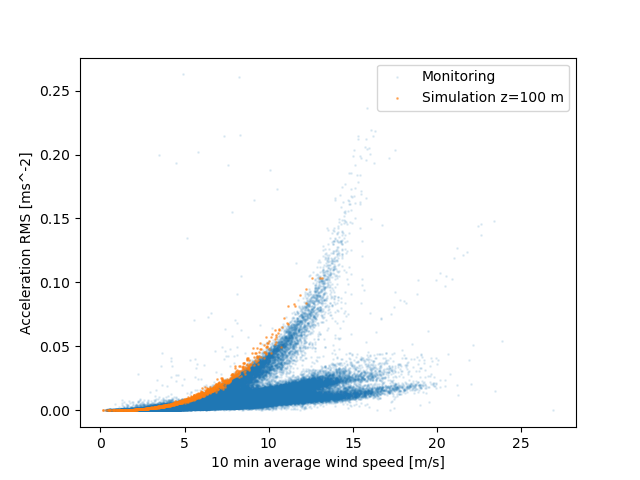

In [39]:
arr = np.load('/usr/scratch4/sima9999/work/modal_uq/v_vs_rms.npz')
v_b = arr['v_b']
rms = arr['rms']
plt.figure()
plt.scatter(stats_wind['mean'], np.sqrt(stats_accel.sel(channels='Accel_02')['rms']**2 + stats_accel.sel(channels='Accel_01')['rms']**2),s=1, alpha=0.1, label='Monitoring')
plt.scatter(v_b, rms[100,:],  s=1, alpha=0.5, label='Simulation z=100 m')
plt.legend()
plt.xlabel('10 min average wind speed [m/s]')
plt.ylabel('Acceleration RMS [ms^-2]')

Continue

 Section 2.2.2
 
 Chapter 1 (Truss description, Wind-Force parameters, example wind response, comparison experimental: wind distribution, rms vs vb)
 
- write down - model description w/ theory, thesis/paperlike:
    - structural model: 
        - guyed mast: simplification, linearization, cross-section w/ rotation, TMD design, further parameters
        - modal solution: method and example, 
    - turbulent wind generation:
        - basic wind parameters (EN 1991),
        - Spectral description, decomposition and time history generation w/ example (run-times), 
        - Force calculation (EN 1991) w/ example
    - model response:
        - transient parameters and example
        - frf parameters and example
        - comparison and run-times
        
Build measurement chain
model uncertainties